In [1]:
!nvidia-smi

Thu Mar 14 20:10:20 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 410.79       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN Xp            Off  | 00000000:01:00.0 Off |                  N/A |
| 34%   48C    P0    72W / 250W |      0MiB / 12195MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
import os

In [3]:
from keras.layers import Input
from keras.layers.core import Dense, Dropout
from keras.models import Model
from keras.losses import categorical_crossentropy, mse
from keras.optimizers import Adadelta, Adam, SGD

Using TensorFlow backend.


In [4]:
def plot_history(history, ymin_loss=None, ymax_loss=None, ymin_acc=None, ymax_acc=None):
    ymin_loss=np.min(history.history['loss'])
    ymax_loss=np.max(history.history['loss'])
    f1 = plt.figure()
    plt.plot(history.history['loss'],label='training')
    plt.plot(history.history['val_loss'],label='validation')
    plt.ylim(ymin_loss,ymax_loss)
    plt.legend(loc='upper right')
    plt.show()
    if 'acc' in history.history:
        ymin_acc=np.min(history.history['acc'])
        ymax_acc=np.max(history.history['acc'])
        f2 = plt.figure()
        plt.plot(history.history['acc'],label='training')
        plt.plot(history.history['val_acc'],label='validation')
        plt.ylim(ymin_acc,ymax_acc)
        plt.legend(loc='upper right')
        plt.show()
    return

In [5]:
data_dir = '/storage/yw18581/data/'
data_folder = os.path.join(data_dir, 'train_validation_test')

In [6]:
X_train = np.load(os.path.join(data_folder, 'Xy_train_dist.npz'))["y"]
y_train = np.load(os.path.join(data_folder, 'Xy_train_dist.npz'))["dist"]

In [7]:
X_val = np.load(os.path.join(data_folder,'Xy_val_dist.npz'))["y"]
y_val = np.load(os.path.join(data_folder, 'Xy_val_dist.npz'))["dist"]

In [8]:
X_test = np.load(os.path.join(data_folder, 'Xy_test_dist.npz'))["y"]
y_test = np.load(os.path.join(data_folder, 'Xy_test_dist.npz'))["dist"]

In [9]:
X_pred = np.load(os.path.join(data_dir, 'trained_models/UNet_training_generator_1500epochs/Xy_test_predicted_UNet.npz'))['y']
y_pred = np.load(os.path.join(data_dir, 'trained_models/UNet_training_generator_1500epochs/Xy_test_predicted_UNet.npz'))['dist']

In [10]:
def cut_X(arr):
    x_cut = arr[:,960:1300,600:]
    if len(x_cut.shape)>3:
        x_cut = x_cut[...,0]
    x_cut_out = x_cut.reshape(x_cut.shape[0],x_cut.shape[1]*x_cut.shape[2])
    return x_cut_out

In [11]:
X_train_cut = cut_X(X_train)

In [12]:
X_val_cut = cut_X(X_val)

In [13]:
X_test_cut = cut_X(X_test)

In [14]:
X_pred_cut = cut_X(X_pred)

In [15]:
def create_model(input_shape):
    input_layer = Input(shape=input_shape,name='input')
    x = Dense(512, activation ='sigmoid')(input_layer)
    #x = Dense(128, activation ='sigmoid')(x)
    #x = Dense(64, activation ='sigmoid')(x)
    #x = Dense(16, activation ='sigmoid')(x)
    x = Dense(8, activation ='sigmoid')(x)
    prediction = Dense(1, activation='linear')(x)
    model = Model(inputs = input_layer, outputs = prediction)
    return model

model = create_model(input_shape=(X_train_cut.shape[1],))
model.compile(loss='mse',
              optimizer=Adadelta())
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input (InputLayer)           (None, 272000)            0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               139264512 
_________________________________________________________________
dense_2 (Dense)              (None, 8)                 4104      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 9         
Total params: 139,268,625
Trainable params: 139,268,625
Non-trainable params: 0
_________________________________________________________________


In [16]:
history = model.fit(X_train_cut, y_train, validation_data=(X_val_cut, y_val),
                    epochs=200, verbose=True, batch_size=16, shuffle=True)

Train on 768 samples, validate on 192 samples
Epoch 1/200
768/768 [==============================] - 13s 17ms/step - loss: 151.3619 - val_loss: 155.6736
Epoch 2/200
768/768 [==============================] - 4s 5ms/step - loss: 145.1869 - val_loss: 149.8392
Epoch 3/200
768/768 [==============================] - 4s 6ms/step - loss: 139.8409 - val_loss: 144.3830
Epoch 4/200
768/768 [==============================] - 4s 5ms/step - loss: 134.8790 - val_loss: 139.3131
Epoch 5/200
768/768 [==============================] - 4s 6ms/step - loss: 130.2505 - val_loss: 134.5559
Epoch 6/200
768/768 [==============================] - 4s 6ms/step - loss: 125.9388 - val_loss: 130.1351
Epoch 7/200
768/768 [==============================] - 4s 5ms/step - loss: 121.9594 - val_loss: 126.0472
Epoch 8/200
768/768 [==============================] - 4s 6ms/step - loss: 118.2810 - val_loss: 122.2416
Epoch 9/200
768/768 [==============================] - 4s 5ms/step - loss: 114.8746 - val_loss: 118.7101
Epoch 1

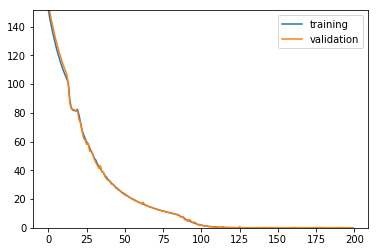

In [17]:
plot_history(history)

In [19]:
model.save(os.path.join(data_dir,'trained_models','leaf_regression_shallow.hdf5'))

In [20]:
preds = model.predict(X_test_cut)

In [27]:
preds.ravel().shape

(240,)

In [22]:
y_test.shape

(240,)

In [29]:
from sklearn.metrics import mean_squared_error as mse

In [30]:
mse(y_test, preds.ravel())

0.026234348483862153

In [31]:
np.unique(y_test)

array([ 2,  4, 10, 25])

In [34]:
t_test_2 = y_test[y_test==2]
t_test_4 = y_test[y_test==4]
t_test_10 = y_test[y_test==10]
t_test_25 = y_test[y_test==25]

In [35]:
print(t_test_2.shape, t_test_4.shape, t_test_10.shape, t_test_25.shape)

(62,) (60,) (60,) (58,)


In [37]:
preds = preds.ravel()

In [38]:
preds

array([25.009554 , 10.109066 ,  2.00716  ,  4.1311665,  2.00716  ,
       25.009554 ,  4.1311665, 25.009554 ,  4.1311665, 10.109066 ,
       10.109066 ,  2.00716  ,  2.00716  , 10.109066 ,  2.00716  ,
        2.00716  ,  4.1311665, 10.109066 , 10.109066 ,  4.1311665,
        4.1311665, 10.109066 , 10.109066 ,  4.1311665,  2.00716  ,
        2.005498 , 10.109066 ,  4.1311665,  4.1311665,  4.1311665,
        4.1311665, 10.109066 , 10.109066 , 10.109066 ,  4.1311665,
        4.1311665,  4.1311665,  2.0060782,  4.1311665, 10.109066 ,
       25.009554 ,  2.00716  , 25.009554 ,  4.1311665, 25.009554 ,
        4.1311665,  4.1311665,  2.00716  ,  2.00716  ,  2.00716  ,
       10.109066 , 25.009554 ,  4.1311665,  2.00716  , 25.009554 ,
        4.1311665, 25.009554 , 25.009554 , 25.009554 ,  4.1311665,
        4.1311665,  2.00716  ,  2.00716  ,  2.00716  ,  2.00716  ,
       25.009554 ,  2.00716  ,  4.1311665,  4.1311665,  4.1311665,
        4.1311665,  2.00716  , 25.009554 ,  2.00716  ,  2.0071

In [39]:
p2 = preds[y_test==2]
p4 = preds[y_test==4]
p10 = preds[y_test==10]
p25 = preds[y_test==25]

In [41]:
mse(t_test_2, p2)

0.07330584099461963

In [42]:
mse(t_test_4, p4)

0.017204395864553135

In [43]:
mse(t_test_10, p10)

0.01189539443294052

In [44]:
mse(t_test_25, p25)

9.127718294621445e-05

In [49]:
from matplotlib.image import imread

In [57]:
w = os.walk(os.path.join(data_dir, "10x10_15mm_v2_8bit_test"))
folder, _, files = next(w)

In [58]:
folder

'/storage/yw18581/data/10x10_15mm_v2_8bit_test'

In [59]:
files

['File_0_15mm_mask_1891.tiff',
 'File_10_15mm_mask_1909.tiff',
 'File_11_15mm_mask_1888.tiff',
 'File_12_15mm_mask_1888.tiff',
 'File_13_15mm_mask_1885.tiff',
 'File_14_15mm_mask_1887.tiff',
 'File_15_15mm_mask_1896.tiff',
 'File_16_15mm_mask_1892.tiff',
 'File_17_15mm_mask_1881.tiff',
 'File_1_15mm_mask_1902.tiff',
 'File_2_15mm_mask_1898.tiff',
 'File_3_15mm_mask_1883.tiff',
 'File_4_15mm_mask_1887.tiff',
 'File_5_15mm_mask_1888.tiff',
 'File_6_15mm_mask_1902.tiff',
 'File_7_15mm_mask_1889.tiff',
 'File_8_15mm_mask_1885.tiff',
 'File_9_15mm_mask_1890.tiff']

In [60]:
gt_15 = [os.path.join(folder, f) for f in files]

In [61]:
gt_15

['/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_0_15mm_mask_1891.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_10_15mm_mask_1909.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_11_15mm_mask_1888.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_12_15mm_mask_1888.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_13_15mm_mask_1885.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_14_15mm_mask_1887.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_15_15mm_mask_1896.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_16_15mm_mask_1892.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_17_15mm_mask_1881.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_1_15mm_mask_1902.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_2_15mm_mask_1898.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_3_15mm_mask_1883.tiff',
 '/storage/yw18581/data/10x10_15mm_v2_8bit_test/File_4_15mm_mask_188

In [67]:
X_15 = [imread(fp)[ROW_SLICE,COL_SLICE] for fp in gt_15]

In [66]:
IMG_WIDTH = 1400
IMG_HEIGHT = 1400
ROW_SLICE = slice(0, 1400)
COL_SLICE = slice(1000, None)


In [70]:
X_15_cut = cut_X(np.asarray(X_15))

In [71]:
preds15 = model.predict(X_15_cut)

In [72]:
preds15

array([[25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554],
       [25.009554]], dtype=float32)